# Example 24: Refinery Margin Prediction with NSGA-II Multi-Objective Optimization

This notebook demonstrates using genetic algorithm feature selection with **NSGA-II multi-objective optimization** for refinery margin prediction.

**Dataset**: Refinery margins with crude oil prices and production data (2006-2023)

**Key Features**:
- Panel/grouped data (multiple countries)
- Many predictors: crude oil prices (brent, dubai, wti), refinery throughput, various margin metrics
- Target: brent_cracking_nw_europe (refinery margin)
- **Enhancement demonstrated**: NSGA-II for balancing performance vs sparsity vs cost

**NSGA-II Benefits**:
- Optimize multiple conflicting objectives simultaneously
- Find Pareto-optimal trade-off solutions
- Balance model accuracy with feature count and computational cost

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from py_recipes import recipe
from py_workflows import workflow
from py_parsnip import linear_reg
from py_yardstick import rmse, mae, r_squared

# Load data
data = pd.read_csv('../_md/__data/refinery_margins.csv')
data['date'] = pd.to_datetime(data['date'])

print(f"Data shape: {data.shape}")
print(f"\nCountries: {sorted(data['country'].unique())}")
print(f"\nDate range: {data['date'].min()} to {data['date'].max()}")
print(f"\nColumns: {list(data.columns)}")
print(f"\nFirst few rows:")
data.head()

Data shape: (1920, 20)

Countries: ['Algeria', 'Denmark', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Romania', 'Russian Federation', 'Turkey', 'United Kingdom']

Date range: 2006-01-01 00:00:00 to 2021-12-01 00:00:00

Columns: ['date', 'country', 'refinery_kbd', 'brent', 'dubai', 'wti', 'brent_cracking_nw_europe', 'brent_hydroskimming_nw_europe', 'urals_cracking_nw_europe', 'urals_hydroskimming_nw_europe', 'es_sider_cracking_med', 'es_sider_hydroskimming_med', 'urals_cracking_med', 'urals_hydroskimming_med', 'dubai_cracking_singapore', 'dubai_hydroskimming_singapore', 'tapis_hydroskimming_singapore', 'x50_50_hls_lls_cracking_usgc', 'x30_70_wcs_bakken_cracking_usmc', 'bakken_coking_usmc']

First few rows:


,date,country,refinery_kbd,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
0,2006-01-01,Algeria,450.0000,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
1,2006-01-01,Denmark,172.9948,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
2,2006-01-01,Germany,2270.5419,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
3,2006-01-01,Italy,1859.7058,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
4,2006-01-01,Netherlands,907.5555,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57


## 1. Data Preparation

Focus on predicting Brent cracking margin in NW Europe using crude prices and other margins.

In [8]:
# Select predictive features (exclude target and non-predictive columns)
target = 'brent_cracking_nw_europe'

# Features to use as predictors
feature_cols = [
    'refinery_kbd',  # Refinery throughput
    'brent', 'dubai', 'wti',  # Crude oil prices
    'brent_hydroskimming_nw_europe',  # Related margin
    'urals_cracking_nw_europe', 'urals_hydroskimming_nw_europe',  # Urals margins
    'es_sider_cracking_med', 'es_sider_hydroskimming_med',  # Mediterranean margins
    'dubai_cracking_singapore', 'dubai_hydroskimming_singapore',  # Singapore margins
    'tapis_hydroskimming_singapore',  # Tapis margin
    'x50_50_hls_lls_cracking_usgc'  # US Gulf Coast margin
]

# Keep only relevant columns
data_model = data[['date', 'country', target] + feature_cols].copy()

# Remove rows with missing target
data_model = data_model.dropna(subset=[target])

print(f"Modeling data shape: {data_model.shape}")
print(f"\nTarget: {target}")
print(f"Features ({len(feature_cols)}): {feature_cols}")

# Train/test split (80/20 by date)
split_date = data_model['date'].quantile(0.8)
train = data_model[data_model['date'] <= split_date].copy()
test = data_model[data_model['date'] > split_date].copy()

print(f"\nTrain: {train.shape[0]} rows, {train['date'].min()} to {train['date'].max()}")
print(f"Test: {test.shape[0]} rows, {test['date'].min()} to {test['date'].max()}")

Modeling data shape: (1920, 16)

Target: brent_cracking_nw_europe
Features (13): ['refinery_kbd', 'brent', 'dubai', 'wti', 'brent_hydroskimming_nw_europe', 'urals_cracking_nw_europe', 'urals_hydroskimming_nw_europe', 'es_sider_cracking_med', 'es_sider_hydroskimming_med', 'dubai_cracking_singapore', 'dubai_hydroskimming_singapore', 'tapis_hydroskimming_singapore', 'x50_50_hls_lls_cracking_usgc']

Train: 1540 rows, 2006-01-01 00:00:00 to 2018-10-01 00:00:00
Test: 380 rows, 2018-11-01 00:00:00 to 2021-12-01 00:00:00


## 2. Baseline: All Features (No Selection)

Establish baseline performance using all 13 features.

In [9]:
# Select one country for demonstration (Germany - large refining capacity)
country = 'Germany'
train_country = train[train['country'] == country].drop(['date', 'country'], axis=1).copy()
test_country = test[test['country'] == country].drop(['date', 'country'], axis=1).copy()

# Remove any remaining NaNs
train_country = train_country.dropna()
test_country = test_country.dropna()

print(f"Training on {country}")
print(f"Train: {train_country.shape}")
print(f"Test: {test_country.shape}")

# Baseline model with all features
baseline_wf = workflow().add_formula(f'{target} ~ .').add_model(linear_reg())
baseline_fit = baseline_wf.fit(train_country)

# Evaluate
baseline_preds = baseline_fit.predict(test_country)
baseline_rmse = rmse(test_country[target], baseline_preds['.pred']).iloc[0]['value']
baseline_mae = mae(test_country[target], baseline_preds['.pred']).iloc[0]['value']
baseline_r2 = r_squared(test_country[target], baseline_preds['.pred']).iloc[0]['value']

print(f"\n=== Baseline (All {len(feature_cols)} Features) ===")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")
print(f"R²: {baseline_r2:.4f}")

Training on Germany
Train: (154, 14)
Test: (38, 14)

=== Baseline (All 13 Features) ===
RMSE: 0.9184
MAE: 0.7754
R²: 0.8514


## 3. Define Feature Costs

Assign hypothetical costs to features based on data acquisition difficulty.

**Cost Categories**:
- High cost: Real-time international margin data (10 units)
- Medium cost: Crude oil prices (5 units)
- Low cost: Local refinery throughput (1 unit)

In [10]:
# Define feature costs (hypothetical)
feature_costs = {
    'refinery_kbd': 1,  # Low cost - local data
    'brent': 5, 'dubai': 5, 'wti': 5,  # Medium cost - crude prices
    'brent_hydroskimming_nw_europe': 7,  # Medium-high cost - regional margin
    'urals_cracking_nw_europe': 10, 'urals_hydroskimming_nw_europe': 10,  # High cost - international margins
    'es_sider_cracking_med': 10, 'es_sider_hydroskimming_med': 10,
    'dubai_cracking_singapore': 10, 'dubai_hydroskimming_singapore': 10,
    'tapis_hydroskimming_singapore': 10,
    'x50_50_hls_lls_cracking_usgc': 10
}

print("Feature costs:")
for feat, cost in sorted(feature_costs.items(), key=lambda x: x[1]):
    print(f"  {feat}: {cost}")

total_cost_all_features = sum(feature_costs.values())
print(f"\nTotal cost of all features: {total_cost_all_features}")

Feature costs:
  refinery_kbd: 1
  brent: 5
  dubai: 5
  wti: 5
  brent_hydroskimming_nw_europe: 7
  urals_cracking_nw_europe: 10
  urals_hydroskimming_nw_europe: 10
  es_sider_cracking_med: 10
  es_sider_hydroskimming_med: 10
  dubai_cracking_singapore: 10
  dubai_hydroskimming_singapore: 10
  tapis_hydroskimming_singapore: 10
  x50_50_hls_lls_cracking_usgc: 10

Total cost of all features: 103


## 4. NSGA-II: Two-Objective Optimization (Performance vs Sparsity)

First, optimize for performance and sparsity (number of features).

In [11]:
# NSGA-II with performance and sparsity objectives
rec_nsga2_2obj = (recipe(train_country)
    .step_select_genetic_algorithm(
        outcome=target,
        model=linear_reg(),
        metric='rmse',
        
        # NSGA-II settings
        use_nsga2=True,
        nsga2_objectives=['performance', 'sparsity'],
        nsga2_selection_method='knee_point',  # Best trade-off
        
        # GA settings
        population_size=50,
        generations=30,
        cv_folds=3,
        random_state=42,
        verbose=True
    ))

prepped_nsga2_2obj = rec_nsga2_2obj.prep(train_country)
selected_2obj = prepped_nsga2_2obj.prepared_steps[0]._selected_features

print(f"\n=== NSGA-II (Performance + Sparsity) ===")
print(f"Selected features ({len(selected_2obj)}): {selected_2obj}")
print(f"\nPareto front size: {len(prepped_nsga2_2obj.prepared_steps[0]._pareto_front)}")

# Evaluate on test set
if len(selected_2obj) > 0:
    train_selected = prepped_nsga2_2obj.bake(train_country)
    test_selected = prepped_nsga2_2obj.bake(test_country)
    
    wf = workflow().add_formula(f'{target} ~ .').add_model(linear_reg())
    fit = wf.fit(train_selected)
    preds = fit.predict(test_selected)
    
    test_rmse = rmse(test_selected[target], preds['.pred']).iloc[0]['value']
    test_mae = mae(test_selected[target], preds['.pred']).iloc[0]['value']
    test_r2 = r_squared(test_selected[target], preds['.pred']).iloc[0]['value']
    
    print(f"\nTest performance:")
    print(f"  RMSE: {test_rmse:.4f} (baseline: {baseline_rmse:.4f})")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  R²: {test_r2:.4f}")
    print(f"  Features reduced: {len(feature_cols)} → {len(selected_2obj)}")

Genetic Algorithm Feature Selection
  Candidate features: 13
  Model: linear_reg
  Metric: rmse (minimize)
  Constraints: 0
  Population size: 50
  Max generations: 30


Running NSGA-II with objectives: ['performance', 'sparsity']
Generation 0: Pareto front size = 1
Generation 10: Pareto front size = 42
Generation 20: Pareto front size = 50
Final Pareto front size: 50

NSGA-II Complete:
  Pareto front size: 50
  Selected solution index: 23
  Selected features: 2/13
  Objective values: [0.29479451 2.        ]
  Features: ['brent', 'wti']

=== NSGA-II (Performance + Sparsity) ===
Selected features (2): ['brent', 'wti']

Pareto front size: 50

Test performance:
  RMSE: 3.2069 (baseline: 0.9184)
  MAE: 2.6052
  R²: -0.8125
  Features reduced: 13 → 2


## 5. NSGA-II: Three-Objective Optimization (Performance + Sparsity + Cost)

Now add cost as third objective to find solutions that balance accuracy, simplicity, AND cost.

In [12]:
# NSGA-II with performance, sparsity, and cost objectives
rec_nsga2_3obj = (recipe(train_country)
    .step_select_genetic_algorithm(
        outcome=target,
        model=linear_reg(),
        metric='rmse',
        
        # Feature costs
        feature_costs=feature_costs,
        
        # NSGA-II settings
        use_nsga2=True,
        nsga2_objectives=['performance', 'sparsity', 'cost'],
        nsga2_selection_method='knee_point',  # Best 3-way trade-off
        
        # GA settings
        population_size=50,
        generations=30,
        cv_folds=3,
        random_state=42,
        verbose=True
    ))

prepped_nsga2_3obj = rec_nsga2_3obj.prep(train_country)
selected_3obj = prepped_nsga2_3obj.prepared_steps[0]._selected_features

print(f"\n=== NSGA-II (Performance + Sparsity + Cost) ===")
print(f"Selected features ({len(selected_3obj)}): {selected_3obj}")

# Calculate cost of selected features
selected_cost = sum(feature_costs.get(f, 0) for f in selected_3obj)
print(f"Total cost: {selected_cost} (baseline: {total_cost_all_features})")
print(f"Cost reduction: {(1 - selected_cost/total_cost_all_features)*100:.1f}%")

print(f"\nPareto front size: {len(prepped_nsga2_3obj.prepared_steps[0]._pareto_front)}")

# Evaluate on test set
if len(selected_3obj) > 0:
    train_selected = prepped_nsga2_3obj.bake(train_country)
    test_selected = prepped_nsga2_3obj.bake(test_country)
    
    wf = workflow().add_formula(f'{target} ~ .').add_model(linear_reg())
    fit = wf.fit(train_selected)
    preds = fit.predict(test_selected)
    
    test_rmse_3obj = rmse(test_selected[target], preds['.pred']).iloc[0]['value']
    test_mae_3obj = mae(test_selected[target], preds['.pred']).iloc[0]['value']
    test_r2_3obj = r_squared(test_selected[target], preds['.pred']).iloc[0]['value']
    
    print(f"\nTest performance:")
    print(f"  RMSE: {test_rmse_3obj:.4f} (baseline: {baseline_rmse:.4f})")
    print(f"  MAE: {test_mae_3obj:.4f}")
    print(f"  R²: {test_r2_3obj:.4f}")
    print(f"  Features reduced: {len(feature_cols)} → {len(selected_3obj)}")
    print(f"  Cost reduced: {total_cost_all_features} → {selected_cost}")

Genetic Algorithm Feature Selection
  Candidate features: 13
  Model: linear_reg
  Metric: rmse (minimize)
  Constraints: 0
  Population size: 50
  Max generations: 30


Running NSGA-II with objectives: ['performance', 'sparsity', 'cost']
Generation 0: Pareto front size = 2
Generation 10: Pareto front size = 47
Generation 20: Pareto front size = 50
Final Pareto front size: 50

NSGA-II Complete:
  Pareto front size: 50
  Selected solution index: 0
  Selected features: 1/13
  Objective values: [0.30055554 1.         5.        ]
  Features: ['wti']

=== NSGA-II (Performance + Sparsity + Cost) ===
Selected features (1): ['wti']
Total cost: 5 (baseline: 103)
Cost reduction: 95.1%

Pareto front size: 50

Test performance:
  RMSE: 3.2390 (baseline: 0.9184)
  MAE: 2.6519
  R²: -0.8491
  Features reduced: 13 → 1
  Cost reduced: 103 → 5


## 6. Compare Different NSGA-II Selection Methods

NSGA-II produces a Pareto front of solutions. Test different selection methods.

In [13]:
selection_methods = ['knee_point', 'min_features', 'best_performance']
method_results = {}

for method in selection_methods:
    print(f"\nTesting selection method: {method}")
    
    rec = (recipe(train_country)
        .step_select_genetic_algorithm(
            outcome=target,
            model=linear_reg(),
            metric='rmse',
            feature_costs=feature_costs,
            use_nsga2=True,
            nsga2_objectives=['performance', 'sparsity', 'cost'],
            nsga2_selection_method=method,
            population_size=50,
            generations=30,
            cv_folds=3,
            random_state=42,
            verbose=False
        ))
    
    prepped = rec.prep(train_country)
    selected = prepped.prepared_steps[0]._selected_features
    
    if len(selected) > 0:
        selected_cost = sum(feature_costs.get(f, 0) for f in selected)
        
        train_selected = prepped.bake(train_country)
        test_selected = prepped.bake(test_country)
        
        wf = workflow().add_formula(f'{target} ~ .').add_model(linear_reg())
        fit = wf.fit(train_selected)
        preds = fit.predict(test_selected)
        
        test_rmse = rmse(test_selected[target], preds['.pred']).iloc[0]['value']
        test_r2 = r_squared(test_selected[target], preds['.pred']).iloc[0]['value']
        
        method_results[method] = {
            'n_features': len(selected),
            'features': selected,
            'cost': selected_cost,
            'rmse': test_rmse,
            'r2': test_r2
        }
        
        print(f"  Selected {len(selected)} features (cost={selected_cost}): {selected}")
        print(f"  RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")


Testing selection method: knee_point
  Selected 1 features (cost=5): ['wti']
  RMSE: 3.2390, R²: -0.8491

Testing selection method: min_features
  Selected 1 features (cost=5): ['wti']
  RMSE: 3.2390, R²: -0.8491

Testing selection method: best_performance
  Selected 3 features (cost=15): ['brent', 'dubai', 'wti']
  RMSE: 3.1932, R²: -0.7971


## 7. Results Summary and Visualization

In [14]:
# Create comparison table
comparison_data = []
comparison_data.append({
    'Method': 'Baseline (All Features)',
    'N Features': len(feature_cols),
    'Cost': total_cost_all_features,
    'RMSE': baseline_rmse,
    'R²': baseline_r2
})

for method, metrics in method_results.items():
    comparison_data.append({
        'Method': f'NSGA-II ({method})',
        'N Features': metrics['n_features'],
        'Cost': metrics['cost'],
        'RMSE': metrics['rmse'],
        'R²': metrics['r2']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n=== Performance Comparison ===")
print(comparison_df.to_string(index=False))

# Calculate improvements
for idx in range(1, len(comparison_df)):
    rmse_improvement = (1 - comparison_df.loc[idx, 'RMSE'] / baseline_rmse) * 100
    cost_reduction = (1 - comparison_df.loc[idx, 'Cost'] / total_cost_all_features) * 100
    print(f"\n{comparison_df.loc[idx, 'Method']}:")
    print(f"  RMSE change: {rmse_improvement:+.1f}%")
    print(f"  Cost reduction: {cost_reduction:.1f}%")


=== Performance Comparison ===
                    Method  N Features  Cost     RMSE        R²
   Baseline (All Features)          13   103 0.918368  0.851351
      NSGA-II (knee_point)           1     5 3.239013 -0.849077
    NSGA-II (min_features)           1     5 3.239013 -0.849077
NSGA-II (best_performance)           3    15 3.193175 -0.797111

NSGA-II (knee_point):
  RMSE change: -252.7%
  Cost reduction: 95.1%

NSGA-II (min_features):
  RMSE change: -252.7%
  Cost reduction: 95.1%

NSGA-II (best_performance):
  RMSE change: -247.7%
  Cost reduction: 85.4%


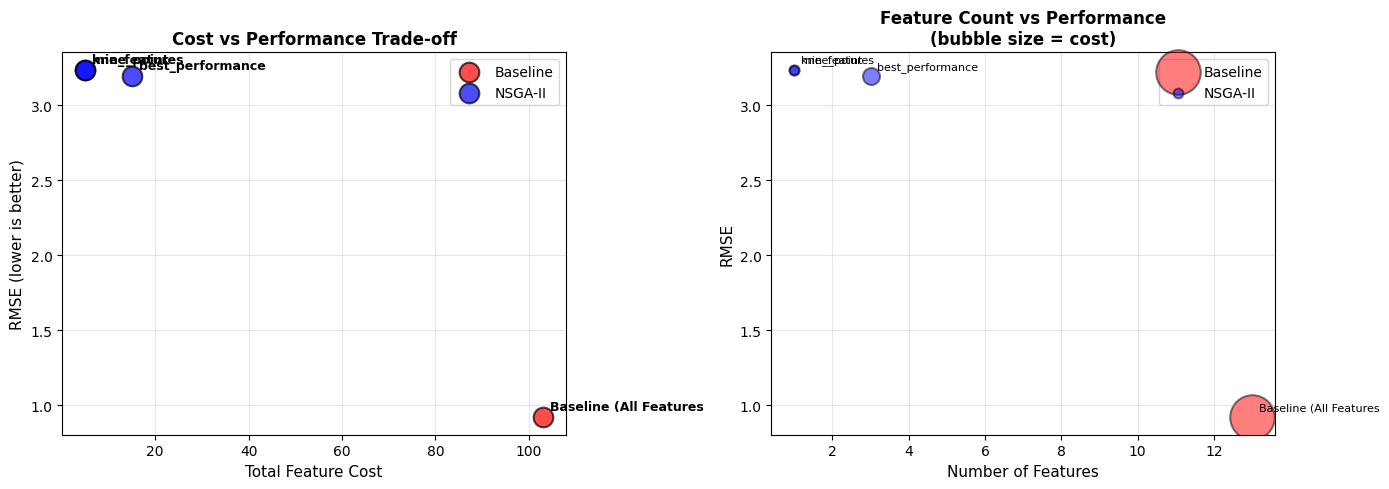


Plot saved as: refinery_margins_nsga2_comparison.png


In [15]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cost vs RMSE trade-off
ax1 = axes[0]
costs = comparison_df['Cost']
rmses = comparison_df['RMSE']
methods = comparison_df['Method']
colors = ['red' if 'Baseline' in m else 'blue' for m in methods]

for i, (c, r, color, m) in enumerate(zip(costs, rmses, colors, methods)):
    label = 'Baseline' if 'Baseline' in m else 'NSGA-II' if i == 1 else None
    ax1.scatter(c, r, s=200, c=color, alpha=0.7, label=label, edgecolors='black', linewidths=1.5)
    ax1.annotate(m.replace('NSGA-II (', '').replace(')', ''), 
                 (c, r), xytext=(5, 5), textcoords='offset points', 
                 fontsize=9, fontweight='bold')

ax1.set_xlabel('Total Feature Cost', fontsize=11)
ax1.set_ylabel('RMSE (lower is better)', fontsize=11)
ax1.set_title('Cost vs Performance Trade-off', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Multi-objective comparison (3D projected to 2D)
ax2 = axes[1]
n_features = comparison_df['N Features']

# Create bubble plot: x=features, y=RMSE, size=cost
for i, (n, r, c, m) in enumerate(zip(n_features, rmses, costs, methods)):
    color = 'red' if 'Baseline' in m else 'blue'
    label = 'Baseline' if 'Baseline' in m else 'NSGA-II' if i == 1 else None
    ax2.scatter(n, r, s=c*10, c=color, alpha=0.5, label=label, edgecolors='black', linewidths=1.5)
    ax2.annotate(m.replace('NSGA-II (', '').replace(')', ''), 
                 (n, r), xytext=(5, 5), textcoords='offset points', 
                 fontsize=8)

ax2.set_xlabel('Number of Features', fontsize=11)
ax2.set_ylabel('RMSE', fontsize=11)
ax2.set_title('Feature Count vs Performance\n(bubble size = cost)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig('refinery_margins_nsga2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as: refinery_margins_nsga2_comparison.png")

## 8. Pareto Front Visualization

Visualize the Pareto front of solutions from the 3-objective optimization.

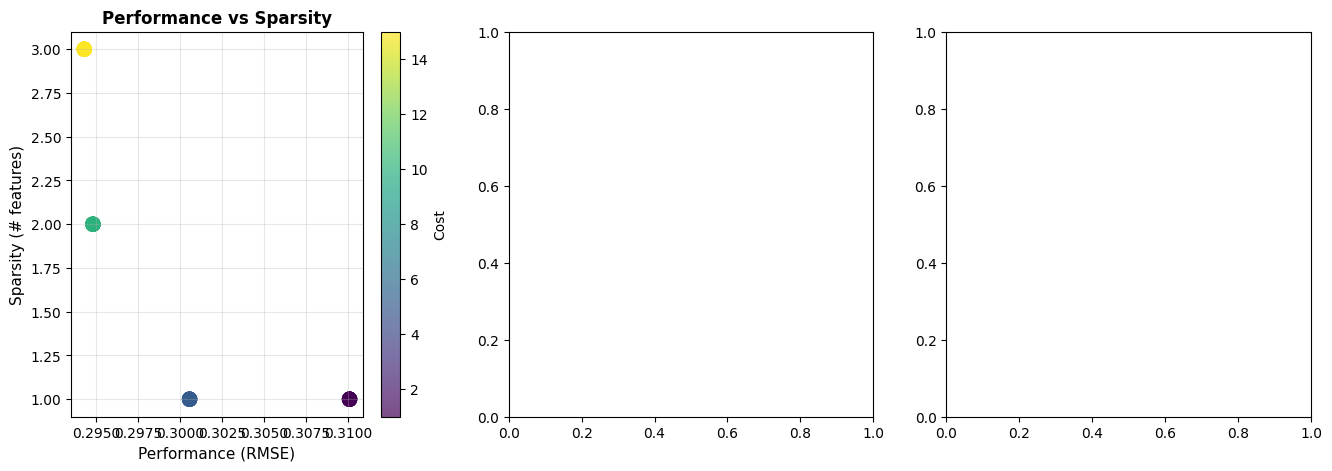

In [17]:
# Extract Pareto front objectives
pareto_objectives = prepped_nsga2_3obj.prepared_steps[0]._pareto_objectives

if pareto_objectives is not None and len(pareto_objectives) > 0:
    # Objectives: [performance, sparsity, cost]
    performance = pareto_objectives[:, 0]
    sparsity = pareto_objectives[:, 1]
    cost_obj = pareto_objectives[:, 2]
    
    # Create 2D projections of 3D Pareto front
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Plot 1: Performance vs Sparsity
    ax1 = axes[0]
    scatter1 = ax1.scatter(performance, sparsity, c=cost_obj, cmap='viridis', s=100, alpha=0.7)
    ax1.set_xlabel('Performance (RMSE)', fontsize=11)
    ax1.set_ylabel('Sparsity (# features)', fontsize=11)
    ax1.set_title('Performance vs Sparsity', fontsize=12, fontweight='bold')
    ax1.grid(alpha=0.3)
    plt.colorbar(scatter1, ax=ax1, label='Cost')
    
    # Mark selected solution (knee point)
    # Calculate knee point index (same method as the step uses internally)
def find_knee_point(objectives):
    """Find knee point using maximum distance from line connecting extremes."""
    if len(objectives) == 1:
        return 0
    
    # Find extreme points
    min_idx = np.argmin(objectives[:, 0])
    max_idx = np.argmax(objectives[:, 1])
    
    if min_idx == max_idx:
        return min_idx
    
    # Calculate distances from line
    p1 = objectives[min_idx]
    p2 = objectives[max_idx]
    
    max_dist = -1
    knee_idx = 0
    
    for i in range(len(objectives)):
        point = objectives[i]
        # Perpendicular distance from point to line
        dist = np.abs(np.cross(p2 - p1, point - p1)) / np.linalg.norm(p2 - p1)
        if dist > max_dist:
            max_dist = dist
            knee_idx = i
    
    return knee_idx

    selected_idx = find_knee_point(pareto_objectives)
    ax1.scatter(performance[selected_idx], sparsity[selected_idx], 
                s=300, c='red', marker='*', edgecolors='black', linewidths=2,
                label='Selected (knee point)', zorder=10)
    ax1.legend()
    
    # Plot 2: Performance vs Cost
    ax2 = axes[1]
    scatter2 = ax2.scatter(performance, cost_obj, c=sparsity, cmap='plasma', s=100, alpha=0.7)
    ax2.set_xlabel('Performance (RMSE)', fontsize=11)
    ax2.set_ylabel('Cost', fontsize=11)
    ax2.set_title('Performance vs Cost', fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)
    plt.colorbar(scatter2, ax=ax2, label='Sparsity')
    
    # Mark selected solution
    ax2.scatter(performance[selected_idx], cost_obj[selected_idx], 
                s=300, c='red', marker='*', edgecolors='black', linewidths=2,
                label='Selected (knee point)', zorder=10)
    ax2.legend()
    
    # Plot 3: Sparsity vs Cost
    ax3 = axes[2]
    scatter3 = ax3.scatter(sparsity, cost_obj, c=performance, cmap='coolwarm', s=100, alpha=0.7)
    ax3.set_xlabel('Sparsity (# features)', fontsize=11)
    ax3.set_ylabel('Cost', fontsize=11)
    ax3.set_title('Sparsity vs Cost', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)
    plt.colorbar(scatter3, ax=ax3, label='Performance')
    
    # Mark selected solution
    ax3.scatter(sparsity[selected_idx], cost_obj[selected_idx], 
                s=300, c='red', marker='*', edgecolors='black', linewidths=2,
                label='Selected (knee point)', zorder=10)
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig('refinery_margins_pareto_front.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nPlot saved as: refinery_margins_pareto_front.png")
    print(f"\nPareto front statistics:")
    print(f"  Number of solutions: {len(performance)}")
    print(f"  Performance range: [{performance.min():.4f}, {performance.max():.4f}]")
    print(f"  Sparsity range: [{int(sparsity.min())}, {int(sparsity.max())}] features")
    print(f"  Cost range: [{cost_obj.min():.0f}, {cost_obj.max():.0f}]")
    print(f"\nSelected solution (knee point):")
    print(f"  Performance: {performance[selected_idx]:.4f}")
    print(f"  Sparsity: {int(sparsity[selected_idx])} features")
    print(f"  Cost: {cost_obj[selected_idx]:.0f}")

## Key Takeaways

1. **NSGA-II Enables Multi-Objective Optimization**: Simultaneously optimize for performance, model simplicity, and data acquisition cost

2. **Pareto Front Reveals Trade-offs**: No single "best" solution - choose based on priorities:
   - `best_performance`: Highest accuracy (may use more features/cost)
   - `min_features`: Simplest model (may sacrifice some accuracy)
   - `knee_point`: Best overall trade-off (recommended)

3. **Cost-Aware Feature Selection**: Incorporating feature costs helps identify economical feature subsets

4. **Three-Objective Balance**: Adding cost objective finds solutions that are accurate, simple, AND economical

5. **Real-World Applicability**: Refinery margin prediction benefits from balancing predictive power with operational constraints (data acquisition costs, model complexity)